In [2]:
import math
import numpy as np
from scipy import integrate
from scipy.stats import norm
from matplotlib import pyplot as plt
import random
import concurrent.futures
import os
import pickle

%matplotlib inline
tau = 2 * math.pi
pi = math.pi
random.seed(666)

import profiles as P

with open("naca0012.dat", "r") as f:
    x, y = np.loadtxt(f, dtype = float, delimiter="\t", unpack = True)

freestream_4 = P.Freestream(u_inf = 1, alpha = 4)

NACA0012 = P.Profile(x,y)
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()
NACA0012.get_aero(freestream_4)
NACA0012.get_limitations()

In [2]:
with (open("gen1", "rb")) as pkl:
    gen1 = pickle.load(pkl)

In [3]:
def penalty_function(profile):
    if profile.roughness < 2:
        return profile.roughness
    else:
        return (profile.roughness-2)**2

CL_NACA0012 = NACA0012.cl
shadow_NACA0012 = NACA0012.shadow
r = 0.1

def general_objective_function(profile,  A: callable, B: callable):
    fitness = A(profile.cl / CL_NACA0012) / B(profile.shadow / shadow_NACA0012) - r * penalty_function(profile)
    if fitness > 0:
        return fitness
    else:
        return 0
    
def objective_function_0(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x)
    
def objective_function_shadow_squared(profile):
    return general_objective_function(profile, lambda x: x, lambda x: x**2)
    
def objective_function_shadow_tangens(profile):
    return general_objective_function(profile, lambda x: x, lambda x: np.tan)

In [4]:
def mutate(p, mu_range = [0, 1], d_range = [-4, 4]):
    """
    mutates a given profile by denting
    mu - allowed range of dent's centre
    d - amplitude for the dent, scaled by NACA0012's vertical shadow
    """
    mu = random.uniform(mu_range[0], mu_range[1])
    d = random.uniform(d_range[0], d_range[1]) * shadow_NACA0012
    p.dent(mu, d)
    p.get_aero(freestream_4)
    p.get_limitations()
    
def chance_mutate(p, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5):
    """
    has a prob probability of mutating profile p. default prob = 1/2
    """
    if random.uniform(0, 1) < prob:
        mutate(p, mu_range, d_range)
    print(f"mutated {p.ID}")
    
def make_children(P, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 10):
    def fun(P):
        return chance_mutate(P, mu_range = mu_range, d_range = d_range, prob = prob)
    children = []
    for i in range(n):
        children.append(P.copy())
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children) 
    print(f"***Finished children of {P.ID}***")
    return children

In [5]:
def roulette_wheel_selection(profiles):
    """
    returns ID of profile winning roulette wheel selection out of the given pool
    """
    total_fitness = sum([p.fitness for p in profiles])
    pick = random.uniform(0, total_fitness)
    current = 0
    for profile in profiles:
        current += profile.fitness
        if current > pick:
            return profile.ID

def crossover(p1, p2, k = None):
    """
    returns a profile crossed from 2 parents (front and back half)
    the slicing is random across the chord, unless specified (k=None)
    """
    x_1, y_1 = p1.x, p1.y
    x_2, y_2 = p2.x, p2.y
    N = len(x_1)

    if not k:
        k = random.uniform(0, 1)
    
    for i, x in enumerate(x_1):
        if x <= k:
            a = i
            b = N - 2 * a
            break
            
    x_upper_back = p1.x[:a]
    x_front = p2.x[a:a + b]
    x_lower_back = p1.x[a + b:]
    y_upper_back = p1.y[:a]
    y_front = p2.y[a:a + b]
    y_lower_back = p1.y[a + b:]
    x = np.concatenate((x_upper_back, x_front, x_lower_back))
    y = np.concatenate((y_upper_back, y_front, y_lower_back))
    return  P.Profile(x, y)

def roulette_crossover(profiles, k = None):
    """
    returns an offspring profile created by crossing 2 specimen in a given generation, using roulette selecting
    """
    p1_ID = roulette_wheel_selection(profiles)
    p2_ID = roulette_wheel_selection([p for p in profiles if p.ID != p1_ID])
    p1 = [p for p in profiles if p.ID == p1_ID ][0]
    p2 = [p for p in profiles if p.ID == p2_ID ][0]
    offspring = crossover(p1, p2, k = k)
    offspring.get_aero(freestream_4)
    offspring.get_limitations()
    return offspring

In [6]:
def create_offspring(profiles, mu_range = [0, 1], d_range = [-4, 4], prob = 0.5, n = 100):
    def fun(P):
        return chance_mutate(P, mu_range, d_range, prob)
    children = []
    for i in range(n):
        children.append(roulette_crossover(profiles))
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(fun, children)
    print(f"***Finished creating offspring***")
    return children   

In [7]:
for p in gen1:
    p.fitness = objective_function_shadow_squared(p)
    print(p.fitness, p.ID)

0.8999999999999996 6306
0.9002335648921062 6307
0.95032482346621 6308
0.8999999999999996 6309
0.954527646284462 6310
1.0121461384716366 6311
1.020557746090013 6312
0.8999999999999996 6313
0.8855616308652245 6314
0.777869495435551 6315
0.9613762423311202 6316
0.8999999999999996 6317
0.7785038997299797 6318
0.9340118712082509 6319
0.8999999999999996 6320
0.8786043302866945 6321
0.8999999999999996 6322
0.8999999999999996 6323
0.8999999999999996 6324
0.840574848363169 6325
0.8340399536189618 6326
1.0700826990438694 6327
1.2083297791592702 6328
0.9032266886550174 6329
0.8863998701212099 6330
0.8715387514983857 6331
0.9219486917046912 6332
0.8999999999999996 6333
0.8999999999999996 6334
0.9013410842441448 6335
0.8582890562909687 6336
0.8999999999999996 6337
0.8999999999999996 6338
0.8975267604356914 6339
0.8855545525549833 6340
0.9010852902491749 6341
0.8514646278364574 6342
0.8999999999999996 6343
0.8999999999999996 6344
0.8999999999999996 6345
0.8999999999999996 6346
0.8999999999999996 634

In [8]:
generations = [gen1]
for i in range(20):
    generations.append(create_offspring(generations[-1], d_range = [-0.01, 0.01], n = 1000, prob = 0.01))
    for p in generations[-1]:
        p.fitness = objective_function_shadow_squared(p)

mutated 2
mutated 3
mutated 4
mutated 5
mutated 6
mutated 7
mutated 8
mutated 9
mutated 10
mutated 11
mutated 12
mutated 13
mutated 14
mutated 15
mutated 16
mutated 17
mutated 18
mutated 19
mutated 20
mutated 21
mutated 22
mutated 23
mutated 24
mutated 25
mutated 26
mutated 27
mutated 28
mutated 29
mutated 30
mutated 31
mutated 32
mutated 33
mutated 34
mutated 35
mutated 36
mutated 37
mutated 38
mutated 39
mutated 40
mutated 41
mutated 42
mutated 43
mutated 44
mutated 45
mutated 46
mutated 47
mutated 48
mutated 49
mutated 50
mutated 51
mutated 52
mutated 53
mutated 54
mutated 55
mutated 56
mutated 57
mutated 58
mutated 59
mutated 60
mutated 61
mutated 62
mutated 63
mutated 64
mutated 65
mutated 66
mutated 67
mutated 68
mutated 69
mutated 70
mutated 71
mutated 72
mutated 73
mutated 74
mutated 75
mutated 76
mutated 77
mutated 78
mutated 79
mutated 80
mutated 81
mutated 82
mutated 83
mutated 84
mutated 85
mutated 86
mutated 87
mutated 88
mutated 89
mutated 90
mutated 91
mutated 93
mutated

104.73764863301271 0
53.195661865413065 -0.6934512796895845
ID of best solution: 19039


[1.2264386603097561,
 4.664894834372326,
 4.703825114282192,
 10.167110704223779,
 10.168536378508996]

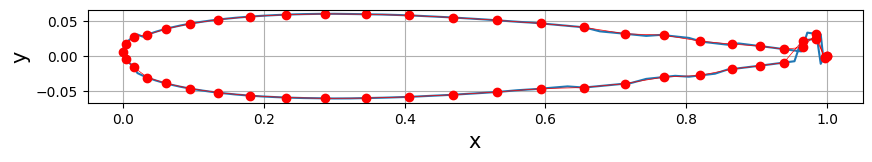

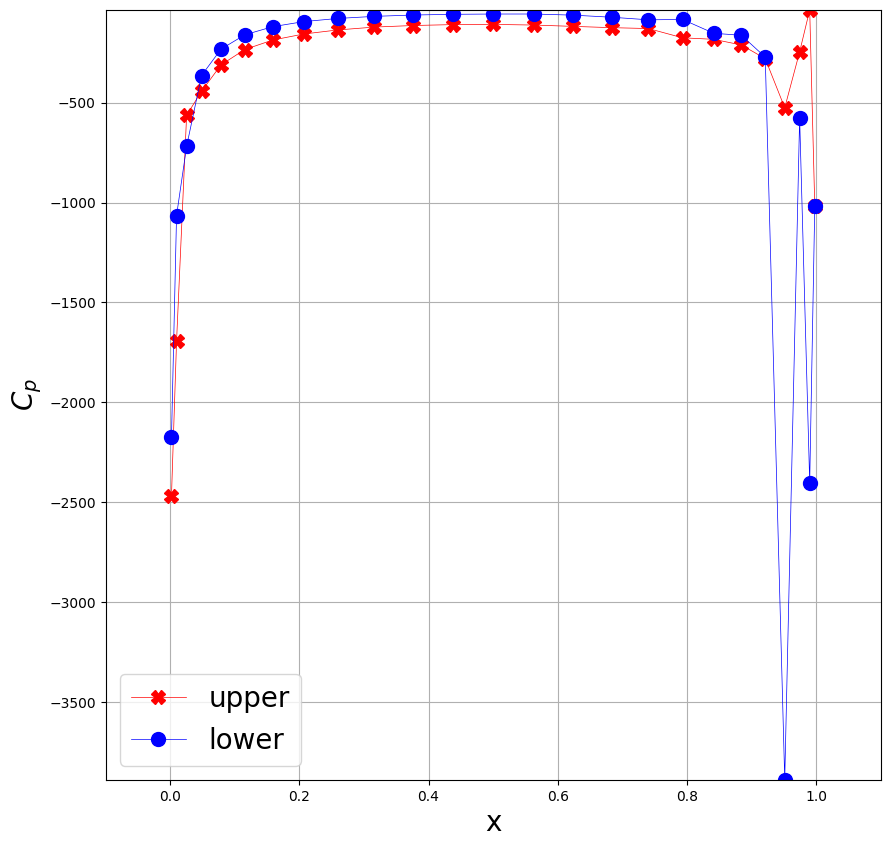

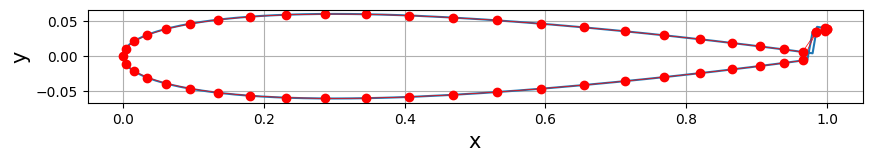

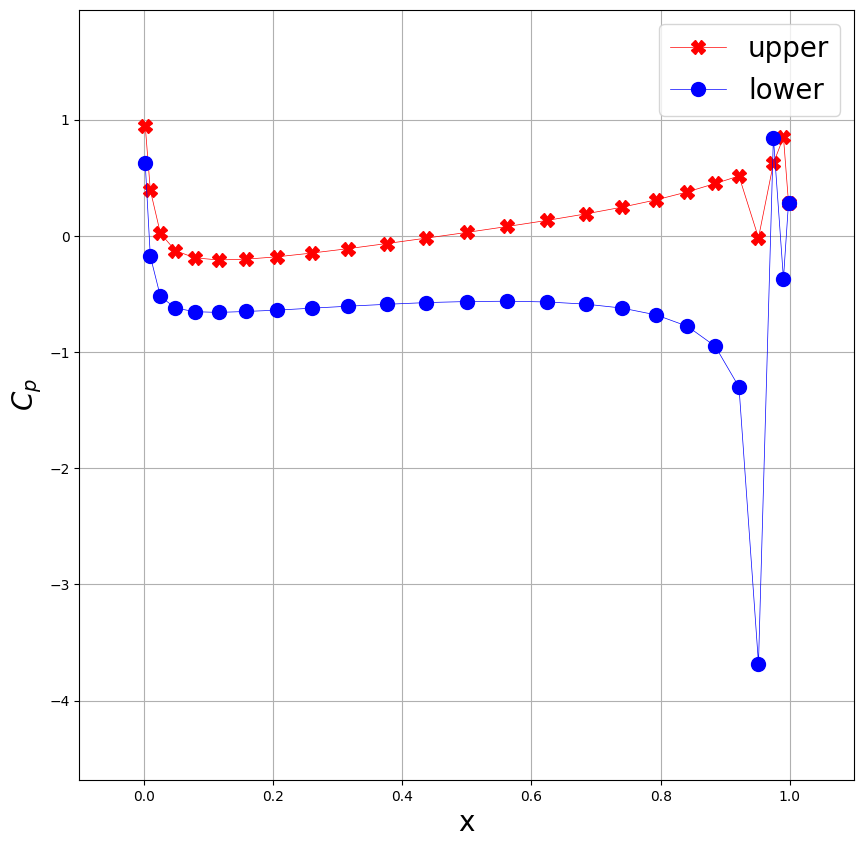

In [9]:
bests = []
worsts = []
for gen in generations:
    bests.append(max(gen, key = lambda x: x.fitness))
    worsts.append(min(gen, key = lambda x: x.fitness))
best = max(bests, key = lambda x: x.fitness)
worst = min(worsts, key = lambda x: x.fitness)
print(best.fitness, worst.fitness)
print(best.cl, worst.cl)
best.draw()
best.draw_cp()
worst.draw()
worst.draw_cp()
print(f"ID of best solution: {best.ID}")
[best.fitness for best in bests][:5]

In [10]:
with open("generations_shadow_squared_prob001", "wb") as pkl:
    pickle.dump(generations, pkl, protocol = pickle.HIGHEST_PROTOCOL)

In [3]:
with (open("generations_shadow_squared_prob001", "rb")) as pkl:
    generations = pickle.load(pkl)

In [4]:
avg_fitness = []
max_fitness = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        for p in gen:
            avg += p.fitness
            maxi = max([maxi, p.fitness])
        avg = avg / len(gen)
        avg_fitness.append((avg, i+1))
        max_fitness.append((maxi, i+1))

In [5]:
avg_fitness_smooth = []
max_fitness_smooth = []
for i, gen in enumerate(generations):
    if i < 60:
        avg = 0
        maxi = 0
        k = 0
        for p in gen:
            if p.roughness < 3:
                avg += p.fitness
                maxi = max([maxi, p.fitness])
                k += 1
        if k != 0:
            avg = avg / k
        else:
            avg = 0
        avg_fitness_smooth.append((avg, i+1))
        max_fitness_smooth.append((maxi, i+1))

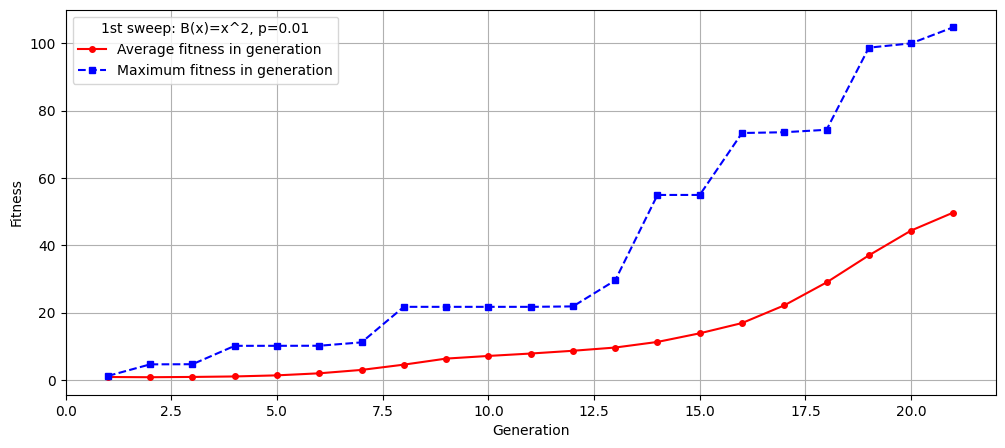

In [6]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation"],
          title = "1st sweep: B(x)=x^2, p=0.01")

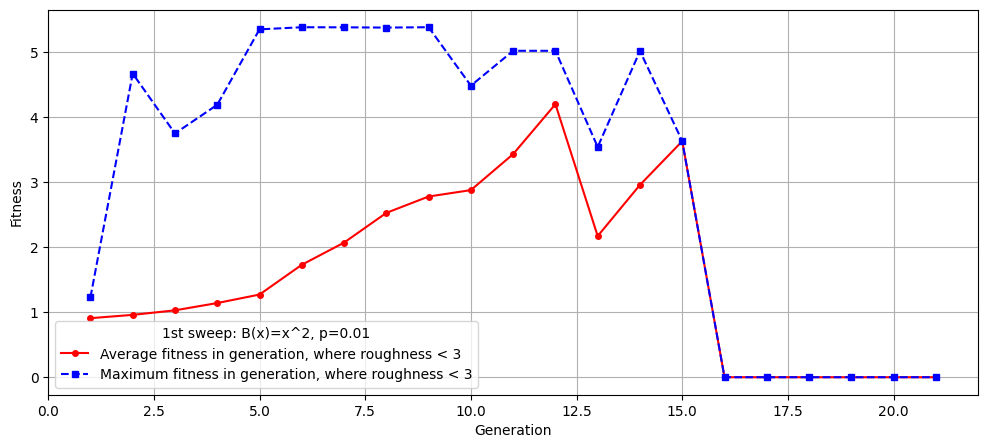

In [7]:
plt.figure(figsize=(12,5))
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "4", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "s", markersize = "4", linestyle = "dashed")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
           title = "1st sweep: B(x)=x^2, p=0.01")

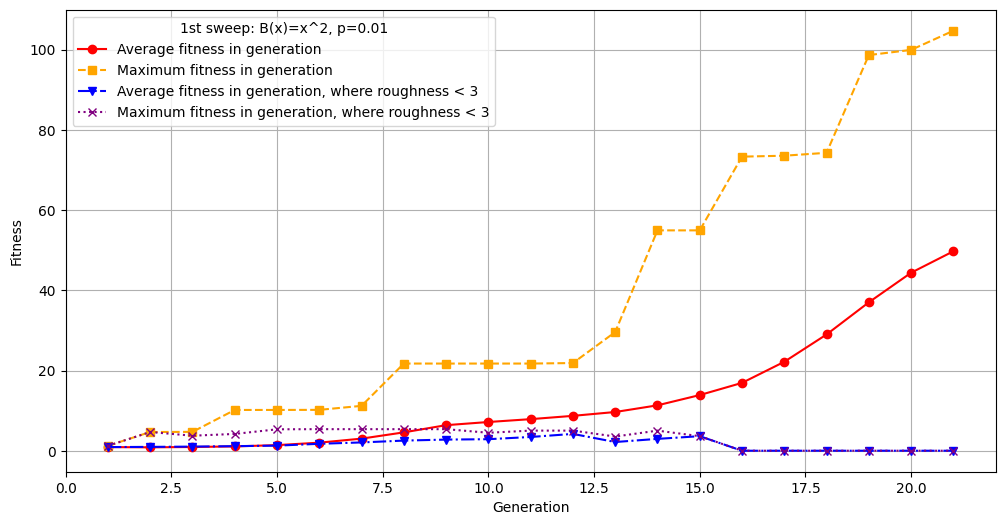

In [8]:
plt.figure(figsize=(12,6))
ytmp, xtmp = zip(*avg_fitness)
plt.plot(xtmp, ytmp, color = "red", marker = "o", markersize = "6", linestyle = "solid")
ytmp, xtmp = zip(*max_fitness)
plt.plot(xtmp, ytmp, color = "orange", marker = "s", markersize = "6", linestyle = "dashed")
ytmp, xtmp = zip(*avg_fitness_smooth)
plt.plot(xtmp, ytmp, color = "blue", marker = "v", markersize = "6", linestyle = "dashdot")
ytmp, xtmp = zip(*max_fitness_smooth)
plt.plot(xtmp, ytmp, color = "purple", marker = "x", markersize = "6", linestyle = "dotted")
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.grid("True")
plt.legend(["Average fitness in generation", "Maximum fitness in generation",
            "Average fitness in generation, where roughness < 3", "Maximum fitness in generation, where roughness < 3"],
          title = "1st sweep: B(x)=x^2, p=0.01")